In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
from sklearn.externals import joblib
import os
import tensorflow as tf
from sklearn.metrics import make_scorer
from matplotlib import pyplot as plt

In [2]:
def CreateModel(max_depth=7, learning_rate=0.2, n_estimators=1500, feature_fraction=1.0, objective='fair', num_leaves=31,
              reg_alpha=0, reg_lambda=0):
    model = lgb.LGBMRegressor(max_depth=max_depth,
                              learning_rate=learning_rate,
                              num_leaves=num_leaves,
                              n_estimators=n_estimators,
                              subsample=0.8,
                              colsample_bytree=0.7,
                              min_child_weight=1,
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                              scale_pos_weight=1,
                              seed=2019,
                              boosting_type='gbdt',
                              feature_fraction=feature_fraction,
                              objective=objective,
                              nthread=32, silent=True)
    return model

In [4]:
DEV = True
NewAidFlag = True
class Config():
    if DEV:
        TRAIN_FILE = "./train_df_v1_10_21_digit.csv"  #train_df_v3_10_21_digit
        DEV_FILE = "./train_df_v1_22_digit.csv"
    else:
        TRAIN_FILE = "./train_df_v1_10_22_digit.csv"
        TEST_FILE = "./test_df_v1_digit.csv"
    

    MODE = "smape" #logloss  smape

    NUM_SPLITS = 5
    RANDOM_SEED = 2019

    if NewAidFlag:
        # drop 'aid_convert_rate', 'aid_convert_rate_t',    , 'len_connectionType',
#            'len_consuptionAbility', 'len_device', 'len_education', 'len_gender',
#            'len_status', 'len_work'
        FEATURE_COLS = [
#             'billing_type',
            'ad_type',
#             'ad_type_convert_rate', 
            'material_size_convert_rate',
            'commodity_id_convert_rate',
            'ad_account_id','ad_industry_id',
            'commodity_id',
            'commodity_type',
            'material_size',
            'ad_industry_id_convert_rate',
            
            
            'ad_account_id_convert_rate',
#             'len_connectionType',
#             'len_consuptionAbility',
            'len_device',
            'len_education', 
#             'len_gender', 
            'len_status', 
#             'len_work',
            
            
            'new_bid',
            'total_aid',
            'len_age', 'len_area', 
        ]
#         #for logloss
#         FEATURE_COLS = ['ad_account_id','ad_account_id_convert_rate',
#            'ad_industry_id', 'ad_industry_id_convert_rate', 'ad_type',
#            'ad_type_convert_rate', 
#            'billing_type', 'commodity_id', 'commodity_id_convert_rate',
#            'commodity_type', 'material_size', 'material_size_convert_rate',
#            'new_bid',  'total_aid', 'weekday']
#, 'len_connectionType',
#            'len_consuptionAbility', 'len_device', 'len_education', 'len_gender',
#            'len_status', 'len_work',
    else:
#         FEATURE_COLS = ['ad_account_id', 'ad_account_id_convert_rate',
#            'ad_industry_id', 'ad_industry_id_convert_rate', 'ad_type',
#            'ad_type_convert_rate', 'aid_convert_rate', 'aid_convert_rate_t',
#            'billing_type', 'commodity_id', 'commodity_id_convert_rate',
#            'commodity_type', 'material_size', 'material_size_convert_rate',
#            'new_bid', 'total_aid', 'weekday','len_age', 'len_area']
        FEATURE_COLS = [   #'last_target',,
#             'billing_type', 'weekday', 'ad_type',
#             'ad_type_convert_rate', 
            'material_size_convert_rate',
            'commodity_id_convert_rate',
            'ad_account_id','ad_industry_id',
#             'commodity_id',
#            'commodity_type',
#             'material_size',
         'len_connectionType', 'len_consuptionAbility',
       'len_device', 'len_education', 'len_gender', 'len_status', 'len_work',
            
             'len_age', 'len_area', 
            
           'new_bid',
            'total_aid',
#             'ad_industry_id_convert_rate',  
#             'ad_account_id_convert_rate',
             'aid_convert_rate',
# #          'aid_convert_rate_max',
#        'aid_convert_rate_mean',
#         'aid_convert_rate_median',
# #        'aid_convert_rate_min',
# #             'target_max', 
#             'target_mean',
#             'target_median',
# #             'target_min'
        ]
    
    
#         #for logloss   'aid_convert_rate', 'aid_convert_rate_t',
#         FEATURE_COLS = ['ad_account_id', 'ad_account_id_convert_rate',
#            'ad_industry_id', 'ad_industry_id_convert_rate', 'ad_type',
#            'ad_type_convert_rate',
#            'billing_type', 'commodity_id', 'commodity_id_convert_rate',
#            'commodity_type', 'material_size', 'material_size_convert_rate',
#            'new_bid', 'total_aid', 'weekday']
        

In [5]:
config = Config()
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
def get_dev(dev,old_aid_set,NewAidFlag):
    old_index = []
    new_index = []
    _dev = dev.copy()
    for index, row in tqdm(_dev.iterrows()):
        if row['ad_id'] in old_aid_set:
            old_index.append(index)
        else:
            new_index.append(index)
    if NewAidFlag:
        return _dev.loc[new_index]
    else:
        return _dev.loc[old_index]
    
def load_data():
    dfTrain = pd.read_csv(config.TRAIN_FILE)
    print(dfTrain.shape)
    if DEV:
        dfDev = pd.read_csv(config.DEV_FILE)
        print(dfDev.shape)
        if config.MODE == 'logloss':
            dfDev=dfDev[dfDev['target'] >= 1]
            dfDev.reset_index(drop=True,inplace=True)
            dfDev['target'] = dfDev.target.apply(lambda x : 1 if x <= 1 else 0)
        else:
            old_aid_set = set(dfTrain.ad_id)
            if NewAidFlag:
                dfDev = get_dev(dfDev,old_aid_set,NewAidFlag)
                dfDev.reset_index(drop=True,inplace=True)
            else:
                dfDev = get_dev(dfDev,old_aid_set,NewAidFlag)
                dfDev.reset_index(drop=True,inplace=True)
            dfDev=dfDev[dfDev['target'] >= 1]
            dfDev.reset_index(drop=True,inplace=True)
        print(dfDev.shape)
    else:
        dfTest = pd.read_csv(config.TEST_FILE)
    if config.MODE == 'logloss':
        dfTrain['target'] = dfTrain.target.apply(lambda x : 1 if x <= 1 else 0)
    else:
        dfTrain['target'] = dfTrain.target.apply(lambda x : 1 if x <= 1 else x)
#         pass

    cols = config.FEATURE_COLS

    X_train = dfTrain[cols].values
    y_train = dfTrain['target'].values
    
    if DEV:
        X_dev = dfDev[cols].values
        y_dev = dfDev['target'].values
    else:
        X_test = dfTest[cols].values
        
    if DEV:
        return dfTrain,dfDev,X_train,y_train,X_dev,y_dev
    else:
        return dfTrain,dfTest,X_train,y_train,X_test

In [6]:
if DEV:
    dfTrain,dfDev,X_train, y_train,X_dev,y_dev = load_data()
else:
    dfTrain,dfTest,X_train,y_train,X_test = load_data()

(677738, 37)
(57380, 37)


57380it [00:02, 21792.87it/s]


(6757, 37)


In [15]:
# 新广告和旧广告参数不一样
# model = CreateModel(n_estimators=20000, max_depth=6, learning_rate=0.01,
#                       feature_fraction=0.6, objective='fair', num_leaves=15,
#                        reg_alpha=3, reg_lambda=0.5)
model = CreateModel(n_estimators=1000, max_depth=6, learning_rate=0.015,
                      feature_fraction=0.3, objective='fair', num_leaves=15,
                      reg_alpha=1, reg_lambda=1)

In [16]:
model.fit(X_train, y_train, eval_metric='l1', categorical_feature=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],  #  
          early_stopping_rounds=200,eval_set=[(X_dev, y_dev)])
# model.fit(X_train, y_train, eval_metric='l1', categorical_feature=[0,1,2,3,4,5,6,7,8,9,10],  #  [0,1,2,3,4]
#           early_stopping_rounds=200,eval_set=[(X_train[:10000], y_train[:10000])])

C:\Anaconda3\envs\gcg-nlp\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's l1: 6.10437	valid_0's fair: 4.51341
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's l1: 5.96616	valid_0's fair: 4.4042
[3]	valid_0's l1: 5.84356	valid_0's fair: 4.3092
[4]	valid_0's l1: 5.72459	valid_0's fair: 4.21823
[5]	valid_0's l1: 5.61526	valid_0's fair: 4.136
[6]	valid_0's l1: 5.52083	valid_0's fair: 4.06602
[7]	valid_0's l1: 5.43558	valid_0's fair: 4.00353
[8]	valid_0's l1: 5.3387	valid_0's fair: 3.93112
[9]	valid_0's l1: 5.26167	valid_0's fair: 3.87448
[10]	valid_0's l1: 5.19007	valid_0's fair: 3.82352
[11]	valid_0's l1: 5.12378	valid_0's fair: 3.77634
[12]	valid_0's l1: 5.06237	valid_0's fair: 3.73356
[13]	valid_0's l1: 5.00517	valid_0's fair: 3.69441
[14]	valid_0's l1: 4.95133	valid_0's fair: 3.65729
[15]	valid_0's l1: 4.89959	valid_0's fair: 3.62172
[16]	valid_0's l1: 4.84954	valid_0's fair: 3.58775
[17]	valid_0's l1: 4.8065	valid_0's fair: 3.55922
[18]	valid_0's l1: 4.76552	valid_0's fair: 3.53179
[19]	valid_0's l1: 4.72679	valid_0

[160]	valid_0's l1: 3.93881	valid_0's fair: 3.05683
[161]	valid_0's l1: 3.93847	valid_0's fair: 3.05673
[162]	valid_0's l1: 3.93795	valid_0's fair: 3.05653
[163]	valid_0's l1: 3.93728	valid_0's fair: 3.05617
[164]	valid_0's l1: 3.93649	valid_0's fair: 3.05555
[165]	valid_0's l1: 3.93609	valid_0's fair: 3.05538
[166]	valid_0's l1: 3.93621	valid_0's fair: 3.05554
[167]	valid_0's l1: 3.9364	valid_0's fair: 3.05578
[168]	valid_0's l1: 3.9363	valid_0's fair: 3.05576
[169]	valid_0's l1: 3.93579	valid_0's fair: 3.05553
[170]	valid_0's l1: 3.93541	valid_0's fair: 3.05535
[171]	valid_0's l1: 3.93535	valid_0's fair: 3.05533
[172]	valid_0's l1: 3.93524	valid_0's fair: 3.05543
[173]	valid_0's l1: 3.93518	valid_0's fair: 3.05547
[174]	valid_0's l1: 3.9348	valid_0's fair: 3.05532
[175]	valid_0's l1: 3.93402	valid_0's fair: 3.05457
[176]	valid_0's l1: 3.93398	valid_0's fair: 3.05456
[177]	valid_0's l1: 3.93391	valid_0's fair: 3.05467
[178]	valid_0's l1: 3.93402	valid_0's fair: 3.05467
[179]	valid_0's

[318]	valid_0's l1: 3.93602	valid_0's fair: 3.06164
[319]	valid_0's l1: 3.93605	valid_0's fair: 3.06173
[320]	valid_0's l1: 3.93612	valid_0's fair: 3.06169
[321]	valid_0's l1: 3.93621	valid_0's fair: 3.06181
[322]	valid_0's l1: 3.93597	valid_0's fair: 3.06153
[323]	valid_0's l1: 3.93612	valid_0's fair: 3.06175
[324]	valid_0's l1: 3.9362	valid_0's fair: 3.0618
[325]	valid_0's l1: 3.93629	valid_0's fair: 3.06188
[326]	valid_0's l1: 3.9362	valid_0's fair: 3.06187
[327]	valid_0's l1: 3.93626	valid_0's fair: 3.06195
[328]	valid_0's l1: 3.93706	valid_0's fair: 3.0626
[329]	valid_0's l1: 3.9371	valid_0's fair: 3.06261
[330]	valid_0's l1: 3.93691	valid_0's fair: 3.06246
[331]	valid_0's l1: 3.93659	valid_0's fair: 3.06219
[332]	valid_0's l1: 3.93651	valid_0's fair: 3.06218
[333]	valid_0's l1: 3.93667	valid_0's fair: 3.06227
[334]	valid_0's l1: 3.93676	valid_0's fair: 3.06235
[335]	valid_0's l1: 3.9371	valid_0's fair: 3.06261
[336]	valid_0's l1: 3.93692	valid_0's fair: 3.06245
[337]	valid_0's l1

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       feature_fraction=0.3, importance_type='split', learning_rate=0.015,
       max_depth=6, min_child_samples=20, min_child_weight=1,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, nthread=32,
       num_leaves=15, objective='fair', random_state=None, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=2019, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [10]:
preds = model.predict(X_dev, batch_size=256)
test_dev = pd.DataFrame(dfDev,columns=['ad_id','target'])
test_dev['pred'] = preds  
test_dev['pred'] = test_dev['pred'].apply(lambda x : 1 if x < 1 else x)
# print('smape test_dev',smape(test_dev['target'],test_dev['pred']))
print(smape(test_dev['target'],test_dev['pred']))
print(100-smape(test_dev['target'],test_dev['pred'])/4)

53.59822527458415
86.60044368135397


<Figure size 864x432 with 0 Axes>

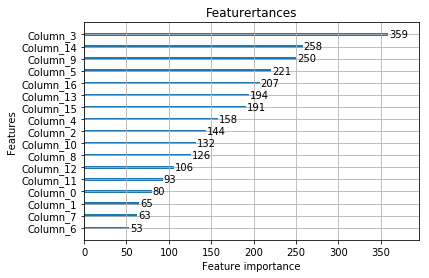

In [14]:
plt.figure(figsize=(12,6))
lgb.plot_importance(model, max_num_features=30)
plt.title("Featurertances")
plt.show()